somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -t b1813 ip_diffim
#setup -k -r .
setup -t 1813 -r .
scons
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import lmfit

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

In [3]:
def singleGaussian2d(x, y, xc, yc, sigma_x=1., sigma_y=1., theta=0., offset=0.):
    cos_theta2, sin_theta2 = np.cos(theta)**2., np.sin(theta)**2.
    sigma_x2, sigma_y2 = sigma_x**2., sigma_y**2.
    a = cos_theta2/(2.*sigma_x2) + sin_theta2/(2.*sigma_y2)
    b = -(np.sin(2.*theta))/(4.*sigma_x2) + (np.sin(2.*theta))/(4.*sigma_y2)
    c = sin_theta2/(2.*sigma_x2) + cos_theta2/(2.*sigma_y2)
    xxc, yyc = x-xc, y-yc
    out = np.exp( - (a*(xxc**2.) + 2.*b*xxc*yyc + c*(yyc**2.)))
    if offset != 0.:
        out += offset
    return out

def generateNoiseImage(z, bg=1.): ##, verbose=True):
    global verbose
    if verbose: 
        npix = np.prod(z.shape)
        print 'SNR:', z.sum(), bg, npix*bg, z.sum() / np.sqrt(z.sum() + 2.*(bg*npix))
    return np.random.poisson(z+bg, z.shape)

def generateStarImage(x, flux, xcen, ycen, psfWidth, sigma2=None, ampl2=0.1, afw=False, noise=0.):
    """
    Stellar thumbnail based on 2-d (potentially [TBD] ellipsoidal) double-gaussian: 
    generateStarImage(x, flux, xcen, ycen, psfWidth, sigma2=None, ampl2=0.1, afw=False, noise=0.)
    """
    if sigma2 is None:
        sigma2 = psfWidth * 1.75
        
    if afw:
        ## Wow - this is about 3x slower than the below (pure python)...
        generator = afwMath.DoubleGaussianFunction2D(psfWidth, sigma2, ampl2)
        zout = np.array([generator(x[0][i] - xcen, x[1][i] - ycen) for i in xrange(len(x[0]))])
        zout *= flux
        if noise != 0.:
            zout = generateNoiseImage(zout, bg=noise**2.)  ## noise generated from poisson

    else: ## don't have stack installed, use a custom double gaussian2d generator. This is faster!
        def singleGaussian2d(x, y, xc, yc, sigma_x=1., sigma_y=1., theta=0., offset=0.):
            cos_theta2, sin_theta2 = np.cos(theta)**2., np.sin(theta)**2.
            sigma_x2, sigma_y2 = sigma_x**2., sigma_y**2.
            a = cos_theta2/(2.*sigma_x2) + sin_theta2/(2.*sigma_y2)
            b = -(np.sin(2.*theta))/(4.*sigma_x2) + (np.sin(2.*theta))/(4.*sigma_y2)
            c = sin_theta2/(2.*sigma_x2) + cos_theta2/(2.*sigma_y2)
            xxc, yyc = x-xc, y-yc
            out = np.exp( - (a*(xxc**2.) + 2.*b*xxc*yyc + c*(yyc**2.)))
            if offset != 0.:
                out += offset
            return out

#      * double Guassian (sum of two Gaussians)
#      *
#      * Intended for use as a PSF model: the main Gaussian represents the core
#      * and the second Gaussian represents the wings.
#      *
#      * f(x,y) = A (e^(-r^2 / 2 sigma1^2) + ampl2 e^(-r^2 / 2 sigma2^2))
#      * where:
#      * * A = 1 / (2 pi (sigma1^2 + ampl2 sigma2^2))
#      * * r^2 = x^2 + y^2
#      * coefficients c[0] = sigma1, c[1] = sigma2, c[2] = ampl2
#       def doubleGaussian2d(x, y, xc, yc, sigma1=1., sigma2=1., ampl2=0.1):
        sigma1 = psfWidth
        multFac = 1.0 / (2. * np.pi)
        sigma1sq = sigma1**2.
        sigma2sq = sigma2**2.
        b = ampl2
#           out = (multFac / (sigma1Sq + (b * sigma2Sq))) *
#              (np.exp(-radSq / (2.0 * sigma1Sq)) + 
#              (b * np.exp(-radSq / (2.0 * sigma2Sq)))));

        tmp1 = singleGaussian2d(x[0], x[1], xcen, ycen, sigma1, sigma1)
        tmp2 = singleGaussian2d(x[0], x[1], xcen, ycen, sigma2, sigma2)
        ampl1 = multFac / (sigma1sq + b * sigma2sq)
        zout = flux * ampl1 * (tmp1 + tmp2 * ampl2)
        if noise != 0.:
            zout = generateNoiseImage(zout, bg=noise**2.)

    return zout

## Note right now we are only fitting one flux value and the 4 positions, not
##   anything related to the shape of the PSF!
def dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg, psfWidth, fluxNeg=None, sigma2=None, ampl2=0.1, afw=False, noise=0.):
    """
    Dipole based on 2-d (potentially [TBD] ellipsoidal) double-gaussian: 
    dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg) #, sig1, sig2)
    """
    if fluxNeg is None:
        fluxNeg = flux
        
    zoutPos = generateStarImage(x, flux,    xcenPos, ycenPos, psfWidth, sigma2=sigma2, ampl2=ampl2, afw=afw, noise=noise)
    zoutNeg = generateStarImage(x, fluxNeg, xcenNeg, ycenNeg, psfWidth, sigma2=sigma2, ampl2=ampl2, afw=afw, noise=noise)
    zoutPos -= zoutNeg
    return zoutPos

def genDipole(w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0.0, flux=3000., noise=1., display=False):
    y, x = np.mgrid[:w, :h]
    x = x.ravel()
    y = y.ravel()
    in_x = [x, y]

    #z = np.array([generator(in_x[0][i] - xc, in_x[1][i] - yc) for i in np.arange(len(in_x[0]))])
    #z *= ht / z.max()
    rotAngRad = rotAngle / 180. * np.pi
    sep = separation / 2.
    z = dipoleFunc(in_x, flux=flux, xcenPos=xc+sep*np.cos(rotAngRad), ycenPos=yc+sep*np.sin(rotAngRad), 
                   xcenNeg=xc-sep*np.cos(rotAngRad), ycenNeg=yc-sep*np.sin(rotAngRad), psfWidth=psfWidth, noise=noise)
    ## DONE: accurate (poisson) noise proportional to pixel intensity. Now inside generateNoiseImage()
    #z += np.random.normal(0., noise+np.sqrt(np.abs(z)), x.shape) #* (0.1 + np.sqrt(np.abs(z)))
    if display:
        #zptp = z.ptp() / 2.
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        plt.imshow(z.reshape(w, h), origin='lower', interpolation='none', cmap='gray' )#, vmin=-zptp, vmax=zptp)
        plt.title("Data")

    return x.reshape(w, h), y.reshape(w, h), z.reshape(w, h)

In [4]:
## Convert to afw image.
def getDipoleExposure(z, psfWidth=2.):
    w, h = z.shape
    image = afwImage.MaskedImageF(w,h)
    image.set(0)
    array = image.getImage().getArray()
    array[:,:] = z
    # Set variance to 1.0 -- TODO, should set variance after adding flux
    var   = image.getVariance().getArray()
    ##var.set(noise)
    var[:,:] = np.abs(z)

    exposure = afwImage.makeExposure(image)
    
    # Create Psf for dipole measurement. Need a psf object too (for source detection below)
    psfSize = int(psfWidth * 20.) + 1
    psf = measAlg.DoubleGaussianPsf(psfSize, psfSize, psfWidth, psfWidth*1.75, 0.1) ## 2.0, 3.5, 0.1)
    psfim = psf.computeImage().convertF()
    psfim /= np.sum(psfim.getArray())
    exposure.setPsf(psf)
    
    return exposure

def detectDipoleSources(z, psfWidth, noise=1., detectSigma=5.0, grow=1, verbose=False, display=False):
    # Detect positive and negative sources in the image. 
    # See meas_algorithms/python/lsst/meas/algorithms/detection.py (SourceDetectionConfig) for config params
    exposure = getDipoleExposure(z, psfWidth=psfWidth)
    w, h = exposure.getWidth(), exposure.getHeight()
    
    config = measAlg.SourceDetectionConfig()
    config.thresholdPolarity = "both"
    config.reEstimateBackground = True
    config.nSigmaToGrow = psfWidth
    config.thresholdValue = detectSigma ##5.0   ## how do we set the detection threshold? Default is 5 sigma, set via config.thresholdValue
    schema = afwTable.SourceTable.makeMinimalSchema()  
    task = measAlg.SourceDetectionTask(schema, config=config)
    table = afwTable.SourceTable.make(schema)
    results = task.makeSourceCatalog(table, exposure, sigma=psfWidth)
#     if display:
#         ds9.mtv(image, frame=4, title="Detection plane")
        
    #if verbose: print len(results.sources)

    if display:
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        
        img_arr, mask_arr, var_arr = exposure.getMaskedImage().getArrays()
        plt.title("Original image")
        plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1,0,h-1), interpolation='none')

        ## first overlay the pos and neg fp centers on the input image and show it.
        for fp in results.fpSets.positive.getFootprints():
            for pk in fp.getPeaks():
                plt.plot(pk.getIx(), pk.getIy(), 'rx')
        for fp in results.fpSets.negative.getFootprints():
            for pk in fp.getPeaks():
                plt.plot(pk.getIx(), pk.getIy(), 'bx')
    
    # Merge them together
    assert(len(results.sources) >= 2)
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, grow, grow, False) ## note used to be tGrow=0, rGrow=0, but sometimes sources were not merged.
    sources = afwTable.SourceCatalog(table)
    fpSet.makeSources(sources)
    assert(len(sources) >= 1)
    
    s = sources[0]
    if verbose:
        print 'N SOURCES:', len(sources)
        for ss in sources: 
            print len(ss.getFootprint().getPeaks())
            if len(ss.getFootprint().getPeaks()) == 2:
                s = ss
            for pk in ss.getFootprint().getPeaks():
                print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()
    
    assert(len(s.getFootprint().getPeaks()) == 2)

    if verbose:
        for pk in s.getFootprint().getPeaks():
            print 'FINAL FOOTPRINT CENTER:', pk.getIy(), pk.getIx()

    if display:
        #plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 2)
        
        img_arr, mask_arr, var_arr = exposure.getMaskedImage().getArrays()
        plt.title("Original image")
        plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1,0,h-1), interpolation='none')
        #plt.plot(xp, yp, 'bx')
        #plt.plot(xn, yn, 'bx')

        ## first overlay the fp centers on the input image and show it.
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIx(), pk.getIy(), 'rx')

        plt.subplot(1, 3, 3)
        img_arr, mask_arr, var_arr = exposure.getMaskedImage().getArrays()
        plt.title("Detection plane")
        plt.imshow(mask_arr, origin='lower', vmin=-100, vmax=100, cmap='gray', extent=(0,w-1,0,h-1), interpolation='none')
        for pk in s.getFootprint().getPeaks():
            plt.plot(pk.getIx(), pk.getIy(), 'rx')
        
    return s

In [5]:
def fitDipole(z, psfWidth=2., cenPos=None, cenNeg=None, verbose=False, display=False):
    """fitDipole(z, psfWidth=2., verbose=False, display=False, cenPos=None, cenNeg=None))
        Starting centroids may be provided as tuple/array coordinates of centroids of positive and negative lobes.
        If these are None, then assume they are the max/min of the stamp.
    """
    w, h = z.shape
    y, x = np.mgrid[:w, :h]
    z = z.ravel()
    x = x.ravel()
    y = y.ravel()
    in_x = [x, y]

    ## For close/faint dipoles the starting locs (min/max) might be way off, let's help them a bit:
    centroidRange = psfWidth * 3.
    if cenPos is None:
        cenPos = np.array(np.unravel_index(np.argmax(z), (w,h)))
    ## Note - this may be a cheat to assume the dipole is centered in center of the stamp.
    if np.sum(np.sqrt((np.array(cenPos) - np.array([w/2, h/2]))**2.)) > centroidRange:
        cenPos = np.array([w/2., h/2.])
    if cenNeg is None:
        cenNeg = np.array(np.unravel_index(np.argmin(z), (w,h)))
    if np.sum(np.sqrt((np.array(cenNeg) - np.array([w/2, h/2]))**2.)) > centroidRange:
        cenNeg = np.array([w/2., h/2.])

    gmod = lmfit.Model(dipoleFunc, verbose=verbose)
    startingFlux = np.abs(z).sum() #/ sep * psfWidth #z.ptp() / 2.  ## ptp = max-min
    
#     if   minPos[0] < xc-centroidRange: minPos[0] = xc-centroidRange
#     elif minPos[0] > xc+centroidRange: minPos[0] = xc+centroidRange
#     if   minPos[1] < yc-centroidRange: minPos[1] = yc-centroidRange
#     elif minPos[1] > yc+centroidRange: minPos[1] = yc+centroidRange
#     if   maxPos[0] < xc-centroidRange: maxPos[0] = xc-centroidRange
#     elif maxPos[0] > xc+centroidRange: maxPos[0] = xc+centroidRange
#     if   maxPos[1] < yc-centroidRange: maxPos[1] = yc-centroidRange
#     elif maxPos[1] > yc+centroidRange: maxPos[1] = yc+centroidRange

    ## parameter hints/constraints: https://lmfit.github.io/lmfit-py/model.html#model-param-hints-section
    gmod.set_param_hint('xcenPos', value=cenPos[0], min=cenPos[0]-centroidRange, max=cenPos[0]+centroidRange)
    gmod.set_param_hint('ycenPos', value=cenPos[1], min=cenPos[1]-centroidRange, max=cenPos[1]+centroidRange)
    gmod.set_param_hint('xcenNeg', value=cenNeg[0], min=cenNeg[0]-centroidRange, max=cenNeg[0]+centroidRange)
    gmod.set_param_hint('ycenNeg', value=cenNeg[1], min=cenNeg[1]-centroidRange, max=cenNeg[1]+centroidRange)
    gmod.set_param_hint('flux', value=startingFlux, min=0.1, max=startingFlux * 2.)  ## TBD: higher flux limit? 
    gmod.set_param_hint('fluxNeg', value=startingFlux, min=0.1, max=startingFlux * 2.)  ## TBD: higher flux limit? 
    gmod.set_param_hint('psfWidth', value=psfWidth, vary=False)
    gmod.set_param_hint('sigma2', value=psfWidth * 1.75, vary=False)
    gmod.set_param_hint('ampl2', value=0.1, vary=False)
    gmod.set_param_hint('noise', value=0., vary=False)
        
    result = gmod.fit(z, #weights=1.0/np.sqrt(np.abs(z))+1.0, 
                      x=in_x, flux=startingFlux, fluxNeg=startingFlux, 
                      xcenPos=cenPos[0], ycenPos=cenPos[1], 
                      xcenNeg=cenNeg[0], ycenNeg=cenNeg[1], verbose=verbose) #, sig1=1., sig2=2.)
    
    if verbose: 
        print(result.fit_report(show_correl=False))
        ## This is how to get confidence intervals out, see here: https://lmfit.github.io/lmfit-py/confidence.html and 
        ##    here: http://cars9.uchicago.edu/software/python/lmfit/model.html
        ## Note this calc takes a long time (longer than the fit!)
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    if display:
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 2)
        plt.imshow(result.best_fit.reshape(w, h), origin='lower', interpolation='none', cmap='gray')#, vmin=-zptp, vmax=zptp)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        plt.imshow(z.reshape(w, h) - result.best_fit.reshape(w, h), origin='lower', cmap='gray', interpolation='none')
        plt.title("Residual")
        
    return result

def genDipoleAndFitIt(z=None, w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0., flux=100., 
                        noise=1., sCat=None, verbose=False, display=False):
    from collections import namedtuple
    resultsOutput = namedtuple('resultsOutput', 
        'inputCentroidX inputCentroidY inputSeparation inputRotation inputFlux inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')

    if z is None:
        _, _, z = genDipole(w=w, h=h, xc=xc, yc=yc, psfWidth=psfWidth, separation=separation, rotAngle=rotAngle,
                        flux=flux, noise=noise, display=display)
    
    pk1 = pk2 = None
    if sCat is None:
        try:
            sCat = detectDipoleSources(z, psfWidth=psfWidth, noise=noise, verbose=verbose, display=display)
            pks = sCat.getFootprint().getPeaks()
            pk1 = pks[0].getF() #)[::-1]  ## need to switch x,y ?? No.
            pk2 = pks[1].getF() #)[::-1]
        except AssertionError:  ## Unlike the ip_diffim code, this can still run. But to be fair, just return NA.
            #print 'HERE', flux, separation
            #pass
            out = resultsOutput(xc, yc, separation, rotAngle, flux, np.nan, np.nan, np.nan, np.nan,
                                np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.inf)
            return out

    #print separation, flux, np.abs(z).sum()
    result = fitDipole(z, psfWidth=psfWidth, cenPos=pk1, cenNeg=pk2, verbose=verbose, display=display)

    rotAngRad = rotAngle / 180. * np.pi
    xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)
    results = result.best_values
    
    centroid = ((results['xcenPos']+results['xcenNeg'])/2., (results['ycenPos']+results['ycenNeg'])/2.)
    dx, dy = results['xcenPos']-results['xcenNeg'], results['ycenPos']-results['ycenNeg']
    angle = np.arctan2(dy, dx) / np.pi * 180.

    fluxVal, fluxErr = result.params['flux'].value, result.params['flux'].stderr
    fluxValNeg, fluxErrNeg = result.params['fluxNeg'].value, result.params['fluxNeg'].stderr
    signalToNoise = np.sqrt((fluxVal/fluxErr)**2 + (fluxValNeg/fluxErrNeg)**2) ## This is from DipoleAnalysis code
        
    out = resultsOutput(xc, yc, separation, rotAngle, flux, xp, yp, xn, yn, 
                        results['xcenPos'], results['ycenPos'], results['xcenNeg'], results['ycenNeg'],
                        fluxVal, -fluxValNeg, centroid[0], centroid[1], angle, signalToNoise)

    return out #.best_values

In [6]:
## I think this is the meat of the ip_diffim code that runs the measurement. 
def measureDipole(s, exposure, dipoleCentroid):
    msConfig = ipDiffim.DipoleMeasurementConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("centroid_x", type=float)
    schema.addField("centroid_y", type=float)
    schema.addField("centroid_flag", type='Flag')
    task = ipDiffim.DipoleMeasurementTask(schema, config=msConfig)
    measCat = afwTable.SourceCatalog(schema)
    measCat.defineCentroid("centroid")
    source = measCat.addNew()
    source.set("centroid_x", dipoleCentroid[0])
    source.set("centroid_y", dipoleCentroid[1])
    source.setFootprint(s.getFootprint())

    #print 'DIPOLE: ', source.get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    # Then run the default SFM task.  Results not checked
    task.run(measCat, exposure)
    return measCat[0] 

def genDipoleAndFitIt_ipDiffim(z=None, w=100, h=100, xc=50., yc=50., psfWidth=2., separation=2., rotAngle=0., flux=100., 
                        noise=1., sCat=None, verbose=False, display=False):
    from collections import namedtuple
    resultsOutput = namedtuple('resultsOutput', 
        'inputCentroidX inputCentroidY inputSeparation inputRotation inputFlux inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')

    if z is None:
        _, _, z = genDipole(w=w, h=h, xc=xc, yc=yc, psfWidth=psfWidth, separation=separation, rotAngle=rotAngle,
                        flux=flux, noise=noise, display=display)
    
    pk1 = pk2 = (xc, yc)
    if sCat is None:
        try:
            sCat = detectDipoleSources(z, psfWidth=psfWidth, noise=noise, verbose=verbose, display=display)
            pks = sCat.getFootprint().getPeaks()
            pk1 = pks[0].getF() #)[::-1]  ## need to switch x,y ?? No.
            pk2 = pks[1].getF() #)[::-1]
        except AssertionError:  ## This fitting won't work unless there's a valid source catalog. If not, return NA.
            #print 'HERE', flux, separation
            #pass
            out = resultsOutput(xc, yc, separation, rotAngle, flux, np.nan, np.nan, np.nan, np.nan,
                                np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.inf)
            return out

    dipoleCentroid = (np.int(np.mean([pk1[0], pk2[0]])), np.int(np.mean([pk1[1], pk2[1]])))
    #print dipoleCentroid
    exposure = getDipoleExposure(z, psfWidth=psfWidth)
    result = measureDipole(sCat, exposure, dipoleCentroid=dipoleCentroid)
    #return result[0]
    
    ## provides (S/N, position, orientation) of measured dipoles
    dpAnalysis = ipDiffim.DipoleAnalysis()
    sn, centroid, orientation = dpAnalysis(result)

    rotAngRad = rotAngle / 180. * np.pi
    xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)

    out = resultsOutput(xc, yc, separation, rotAngle, flux, xp, yp, xn, yn, 
        result.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), result.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"),
        result.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), result.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"),
        result.get("ip_diffim_PsfDipoleFlux_pos_flux"), result.get("ip_diffim_PsfDipoleFlux_neg_flux"),
        centroid.getX(), centroid.getY(), orientation, sn)
    return out

-143.833908169 127.833908169 7353.34571756
-62.3382 61.8499 4334.65
resultsOutput(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.4, inputRotation=0.0, inputFlux=3000.0, inputPosCentroidX=26.199999999999999, inputPosCentroidY=25.0, inputNegCentroidX=23.800000000000001, inputNegCentroidY=25.0, psfFitPosCentroidX=24.999142897478482, psfFitPosCentroidY=26.236854858958015, psfFitNegCentroidX=24.989471610038759, psfFitNegCentroidY=23.758228826233982, psfFitPosFlux=2940.5056966779443, psfFitNegFlux=-2949.7486371670648, psfFitCentroidX=24.99430725375862, psfFitCentroidY=24.997541842596, psfFitOrientation=89.776440199790386, psfFitSignaltoNoise=69.017331405786607)
resultsOutput(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.4, inputRotation=0.0, inputFlux=3000.0, inputPosCentroidX=26.199999999999999, inputPosCentroidY=25.0, inputNegCentroidX=23.800000000000001, inputNegCentroidY=25.0, psfFitPosCentroidX=25.002302697883536, psfFitPosCentroidY=26.23559053874338, psfFitNe

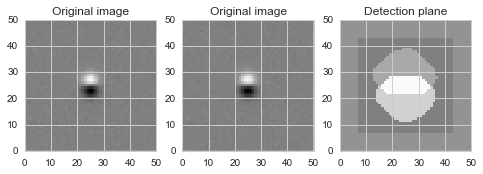

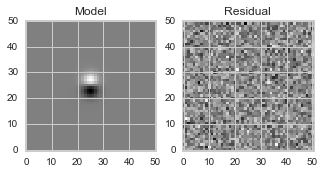

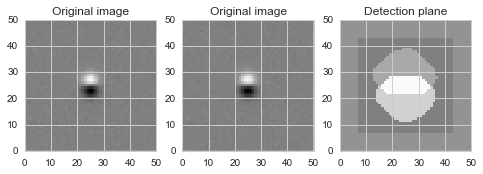

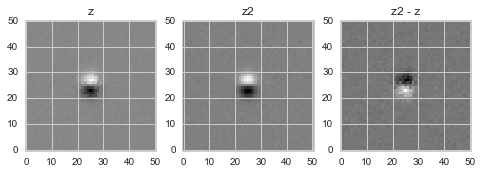

In [29]:
import cPickle as pickle
img_arr = pickle.load( open( "save.p", "rb" ) )
z2 = img_arr

x, y, z = genDipole(w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2.4, rotAngle=90., 
                flux=3000., noise=1., display=False)

print z.min(), z.max(), np.abs(z).sum()
print z2.min(), z2.max(), np.abs(z2).sum()

result = genDipoleAndFitIt(z=z2, w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2.4, rotAngle=0.,
                              flux=3000., noise=1., verbose=False, display=True)
print result

result = genDipoleAndFitIt_ipDiffim(z=z2, w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2.4, rotAngle=0.,
                              flux=3000., noise=1., verbose=False, display=True)
print result

plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='none', cmap='gray')#, vmin=-zptp, vmax=zptp)
plt.title("z")
plt.subplot(1, 3, 2)
plt.imshow(z2, origin='lower', cmap='gray', interpolation='none')
plt.title("z2")
plt.subplot(1, 3, 3)
plt.imshow(z2-z, origin='lower', cmap='gray', interpolation='none')
plt.title("z2 - z")

-143.833908169 127.833908169 7353.34571756
-62.3382 61.8499 4334.65
resultsOutput(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.4, inputRotation=0.0, inputFlux=3000.0, inputPosCentroidX=26.199999999999999, inputPosCentroidY=25.0, inputNegCentroidX=23.800000000000001, inputNegCentroidY=25.0, psfFitPosCentroidX=24.999142897478482, psfFitPosCentroidY=26.236854858958015, psfFitNegCentroidX=24.989471610038759, psfFitNegCentroidY=23.758228826233982, psfFitPosFlux=2940.5056966779443, psfFitNegFlux=-2949.7486371670648, psfFitCentroidX=24.99430725375862, psfFitCentroidY=24.997541842596, psfFitOrientation=89.776440199790386, psfFitSignaltoNoise=69.017331405786607)
resultsOutput(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.4, inputRotation=0.0, inputFlux=3000.0, inputPosCentroidX=26.199999999999999, inputPosCentroidY=25.0, inputNegCentroidX=23.800000000000001, inputNegCentroidY=25.0, psfFitPosCentroidX=25.002302697883536, psfFitPosCentroidY=26.23559053874338, psfFitNe

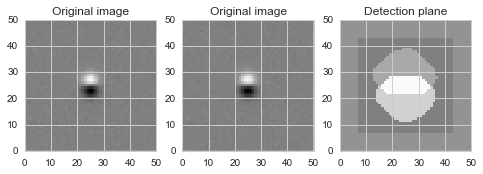

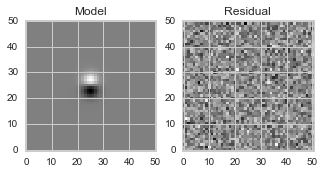

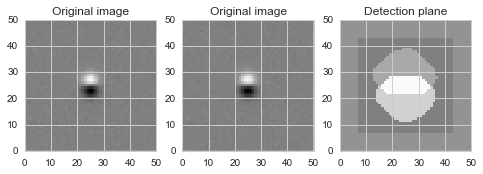

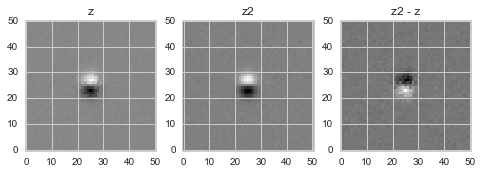

In [29]:
import cPickle as pickle
img_arr = pickle.load( open( "save.p", "rb" ) )
z2 = img_arr

x, y, z = genDipole(w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2.4, rotAngle=90., 
                flux=3000., noise=1., display=False)

print z.min(), z.max(), np.abs(z).sum()
print z2.min(), z2.max(), np.abs(z2).sum()

result = genDipoleAndFitIt(z=z2, w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2.4, rotAngle=0.,
                              flux=3000., noise=1., verbose=False, display=True)
print result

result = genDipoleAndFitIt_ipDiffim(z=z2, w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2.4, rotAngle=0.,
                              flux=3000., noise=1., verbose=False, display=True)
print result

plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='none', cmap='gray')#, vmin=-zptp, vmax=zptp)
plt.title("z")
plt.subplot(1, 3, 2)
plt.imshow(z2, origin='lower', cmap='gray', interpolation='none')
plt.title("z2")
plt.subplot(1, 3, 3)
plt.imshow(z2-z, origin='lower', cmap='gray', interpolation='none')
plt.title("z2 - z")

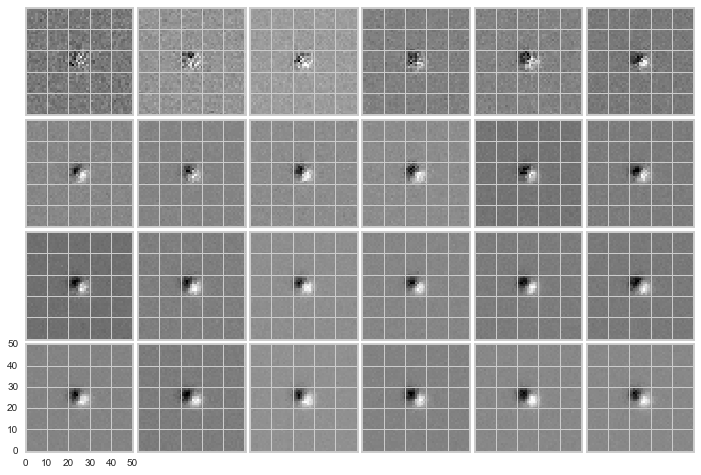

SNR: 2500.0 1.0 2601.0 28.4864448168
SNR: 2500.0 1.0 2601.0 28.4864448168


In [7]:
from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(4, 6),
                axes_pad=0.05,
                label_mode="1")

verbose = False  ## global var, this is bad! This is for "verbose" in generateNoiseImage()
for i,sep in enumerate(np.arange(0.2, 5.0, 0.2)):
    x, y, z = genDipole(w=51, h=51, xc=25., yc=25., psfWidth=2., separation=sep, rotAngle=324., 
                flux=2500., noise=1., display=False)
    im = grid[i].imshow(z, origin='lower', interpolation='none', cmap='gray')
plt.show()

verbose = True
x, y, z = genDipole(w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2., rotAngle=324., 
                flux=2500., noise=1., display=False)
verbose = False

SNR: 250.0 1.0 2601.0 3.38580611555
SNR: 250.0 1.0 2601.0 3.38580611555
SNR: 6000.0 1.0 2601.0 56.689609605
SNR: 6000.0 1.0 2601.0 56.689609605


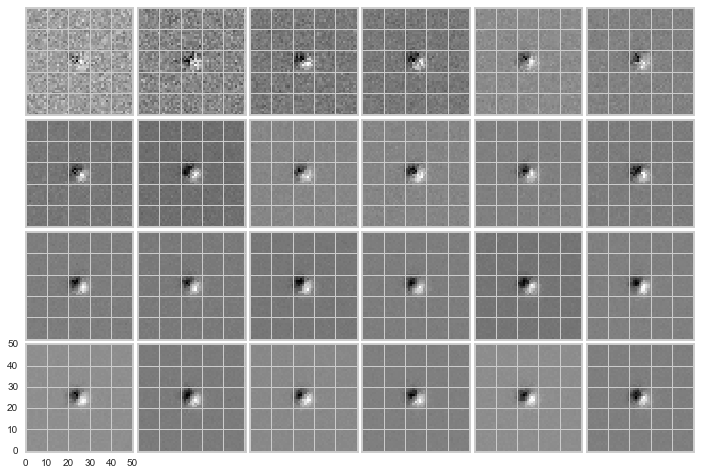

SNR: 2500.0 1.0 2601.0 28.4864448168
SNR: 2500.0 1.0 2601.0 28.4864448168


In [8]:
from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(4, 6),
                axes_pad=0.05,
                label_mode="1")

for i,flux in enumerate(np.arange(250., 6001., 250.)):
    verbose = False
    if flux == 250. or flux == 6000.: verbose = True
    x, y, z = genDipole(w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2., rotAngle=324., 
                flux=flux, noise=1., display=False)
    im = grid[i].imshow(z, origin='lower', interpolation='none', cmap='gray')
plt.show()

verbose = True
x, y, z = genDipole(w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2., rotAngle=324., 
                flux=2500., noise=1., display=False)
verbose = False

N SOURCES: 1
2
FOOTPRINT CENTER: 23 27
FOOTPRINT CENTER: 27 23
FINAL FOOTPRINT CENTER: 23 27
FINAL FOOTPRINT CENTER: 27 23
[26 23] [25 26]
27.0 23.0
[ 23.  27.]
23.0 27.0


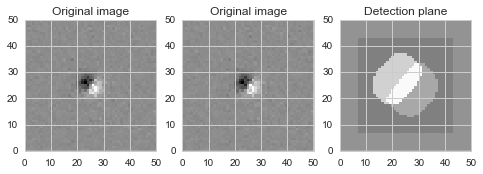

In [9]:
s = detectDipoleSources(z, psfWidth=2., noise=1., verbose=True, display=True)
#for pk in s.getFootprint().getPeaks():
#    print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()
    
maxPos = np.array(np.unravel_index(np.argmax(z), (51,51)))
minPos = np.array(np.unravel_index(np.argmin(z), (51,51)))
print minPos, maxPos

tmp = s.getFootprint().getPeaks()[0].getF()
print tmp[0], tmp[1]
print np.array(tmp)[::-1]

tmp = s.getFootprint().getPeaks()[1].getF()
print tmp[0], tmp[1]

10 loops, best of 3: 40.3 ms per loop
 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter for hint "fluxNeg"
 - Adding parameter for hint "psfWidth"
 - Adding parameter for hint "sigma2"
 - Adding parameter for hint "ampl2"
 - Adding parameter for hint "noise"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
 - Adding parameter "psfWidth"
 - Adding parameter "ampl2"
 - Adding parameter "noise"
 - Adding parameter "fluxNeg"
 - Adding parameter "sigma2"
[[Model]]
    Model(dipoleFunc)
[[Fit Statistics]]
    # function evals   = 108
    # data points      = 2601
    # variables        = 6
    chi-square         = 9806.263
    reduced chi-square = 3.779
[[Variables]]
    xcenPos:    25.8059149 +/- 0.094641 (0.37%) (init= 25)
    ycenPos

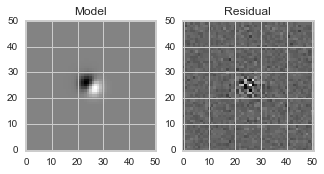

In [10]:
%timeit fitDipole(z, psfWidth=2., verbose=False, display=False)
result = fitDipole(z, psfWidth=2., verbose=True, display=True)

OK, I see that measureDipole is slow because of the psf fitting - in `DipoleAlgorithms.cc`. It seems to take nearly 1s for some fits (especially for closely-separated dipoles).

UPDATE - after compiling with O3, the dipole fitting is ~60ms now!

Why is it slow? Possible reasons:

1. `PsfDipoleFlux::chi2()` computes the PSF *image* (pos. and neg.) to compute the model, rather than using something like `afwMath.DoubleGaussianFunction2D()` as I do above. Or if that is not possible (may need to use a pixelated input PSF) then speed up the computation of the dipole model image (right now it uses multiple vectorized function calls).
2. It spends a lot of time floating around near the minimum and perhaps can be cut off more quickly (note this could be caused by (1.)
3. Perhaps its starting parameters (derived from the naive coordinates) could be made more accurate. At least it looks like the starting flux values are being set way too low (looks like +/- 22.0, should be ~3000 -- how is that being set?)
4. it computes chi2 over the entire subimage (confirm this?) rather than the inner 2,3,4, or 5 sigma of the PSF (or even better within the source's footprint(s)
5. some calculations are computed each time during minimization (in chi2 function) that can be moved outside (not sure if these calc's are really expensive though)

Need to check out -- maybe because dipole fit is so slow, it's not enabled in the main pipelines, thus it uses the naive method by default which is inaccurate.

Note: It seems that the dipole fit is a lot faster for dipoles of greater separation than for those that are closer (it seems the optimization [minuit]) takes longer to converge).

But for now, let's just test the algorithm and worry about timing later.

In [11]:
result = genDipoleAndFitIt(z=z, w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2., rotAngle=0.,
                              flux=2500., noise=1., verbose=False, display=False)
print result

%timeit genDipoleAndFitIt(z=z, w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2., rotAngle=0., \
                              flux=2500., noise=1., verbose=False, display=False)

resultsOutput(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.0, inputRotation=0.0, inputFlux=2500.0, inputPosCentroidX=26.0, inputPosCentroidY=25.0, inputNegCentroidX=24.0, inputNegCentroidY=25.0, psfFitPosCentroidX=25.805924718848892, psfFitPosCentroidY=24.40119540268541, psfFitNegCentroidX=24.269592943858751, psfFitNegCentroidY=25.534820215740339, psfFitPosFlux=2454.1226370533163, psfFitNegFlux=-2515.6149537112119, psfFitCentroidX=25.03775883135382, psfFitCentroidY=24.968007809212875, psfFitOrientation=-36.422785367706574, psfFitSignaltoNoise=13.389740348436225)
10 loops, best of 3: 46.2 ms per loop


In [12]:
result = genDipoleAndFitIt_ipDiffim(z=z, w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2., rotAngle=0.,
                              flux=2500., noise=1., verbose=False, display=False)
print result

%timeit result = genDipoleAndFitIt_ipDiffim(z=z, w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2., rotAngle=0., \
                              flux=2500., noise=1., verbose=False, display=False)

resultsOutput(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.0, inputRotation=0.0, inputFlux=2500.0, inputPosCentroidX=26.0, inputPosCentroidY=25.0, inputNegCentroidX=24.0, inputNegCentroidY=25.0, psfFitPosCentroidX=25.724017078729638, psfFitPosCentroidY=24.53855399884376, psfFitNegCentroidX=24.36435836950361, psfFitNegCentroidY=25.554535100961424, psfFitPosFlux=2570.8462352089696, psfFitNegFlux=-2641.2758518230116, psfFitCentroidX=25.044187724116625, psfFitCentroidY=25.046544549902592, psfFitOrientation=2.21252 rad, psfFitSignaltoNoise=9.9479342799236488)
10 loops, best of 3: 92.6 ms per loop


In [13]:
def genDipoleAndFitBothWays(z=z, w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2., rotAngle=0.,
                              flux=2500., noise=1., verbose=False, display=False):
    if z is None:
        _, _, z = genDipole(w=w, h=h, xc=xc, yc=yc, psfWidth=psfWidth, separation=separation, rotAngle=rotAngle,
                            flux=flux, noise=noise, display=display)

    result1 = genDipoleAndFitIt(z=z, w=w, h=h, xc=xc, yc=yc, psfWidth=psfWidth, separation=separation, rotAngle=rotAngle,
                              flux=flux, noise=noise, verbose=verbose, display=display)
    
    result2 = genDipoleAndFitIt_ipDiffim(z=z, w=w, h=h, xc=xc, yc=yc, psfWidth=psfWidth, separation=separation, rotAngle=rotAngle,
                              flux=flux, noise=noise, verbose=verbose, display=display)
    
    return {'old': result2, 'new': result1}

resultsOutput(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.0, inputRotation=0.0, inputFlux=2500.0, inputPosCentroidX=26.0, inputPosCentroidY=25.0, inputNegCentroidX=24.0, inputNegCentroidY=25.0, psfFitPosCentroidX=25.371810142939484, psfFitPosCentroidY=25.00484487553568, psfFitNegCentroidX=24.824429719350842, psfFitNegCentroidY=25.047844929092577, psfFitPosFlux=7994.6989041088345, psfFitNegFlux=-7950.363468639779, psfFitCentroidX=25.098119931145163, psfFitCentroidY=25.02634490231413, psfFitOrientation=1.64919 rad, psfFitSignaltoNoise=3.712771473927055)
resultsOutput(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.0, inputRotation=0.0, inputFlux=2500.0, inputPosCentroidX=26.0, inputPosCentroidY=25.0, inputNegCentroidX=24.0, inputNegCentroidY=25.0, psfFitPosCentroidX=25.389481838641501, psfFitPosCentroidY=25.069049611688126, psfFitNegCentroidX=24.842814268039842, psfFitNegCentroidY=25.11660333890212, psfFitPosFlux=8499.9968061463951, psfFitNegFlux=-8418.9325741

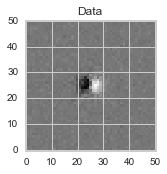

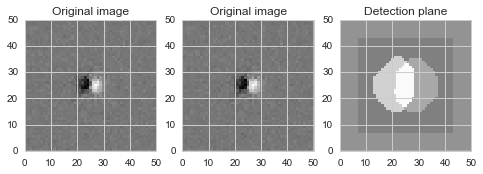

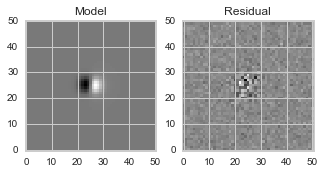

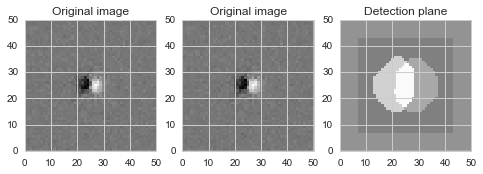

In [14]:
result = genDipoleAndFitBothWays(z=None, w=51, h=51, xc=25., yc=25., psfWidth=2., separation=2., rotAngle=0.,
                                flux=2500., noise=1., verbose=False, display=True)
print result['old']
print result['new']

### First test dipoles of varying separation (same orientation, same flux)

In [15]:
varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

#orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)

inputs = [varTuple(z=None, w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=sep, rotAngle=0., 
                    flux=3000., noise=1., verbose=False, display=False) for i in xrange(10) for sep in separations]

def processInput(i):
    #print i.separation #, i.rotAngle
    output = genDipoleAndFitBothWays(z=i.z, w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfWidth=i.psfWidth, separation=i.separation, 
                                 rotAngle=i.rotAngle, flux=i.flux, noise=i.noise, verbose=False, display=False)
    output['new'] = output['new']._asdict()
    output['old'] = output['old']._asdict()
    return output

num_cores = multiprocessing.cpu_count() / 2
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

(22, 28)

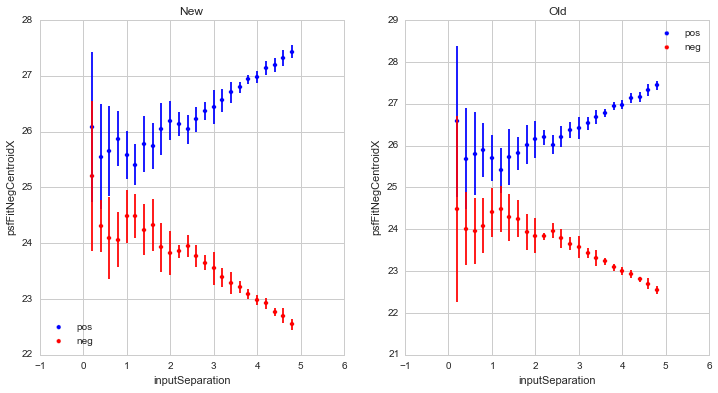

In [29]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosCentroidX', kind='scatter', yerr=tmp_df2['psfFitPosCentroidX'], color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation', y='psfFitNegCentroidX', kind='scatter', yerr=tmp_df2['psfFitNegCentroidX'], color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosCentroidX', kind='scatter', yerr=tmp_df2['psfFitPosCentroidX'], color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation', y='psfFitNegCentroidX', kind='scatter', yerr=tmp_df2['psfFitNegCentroidX'], color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([22,28])
axes[1].set_title('Old')
axes[0].set_ylim([22,28])

(-1.2, 2.5)

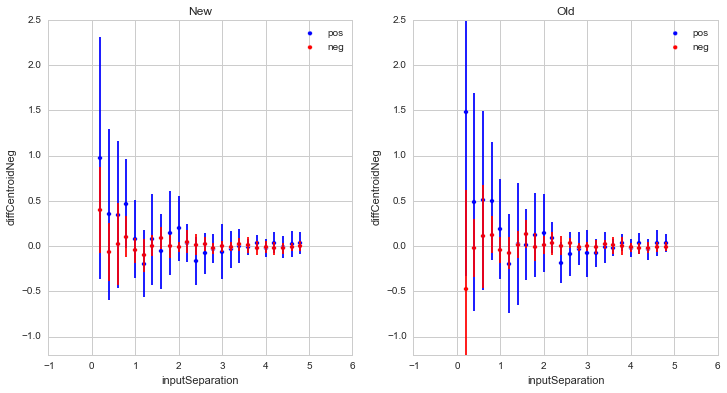

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
df['diffCentroidPos'] = df.psfFitPosCentroidX - df.inputPosCentroidX
df['diffCentroidNeg'] = df.psfFitNegCentroidY - df.inputNegCentroidY
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='diffCentroidPos', kind='scatter', yerr=tmp_df2['diffCentroidPos'], color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation', y='diffCentroidNeg', kind='scatter', yerr=tmp_df2['diffCentroidNeg'], color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results])
df['diffCentroidPos'] = df.psfFitPosCentroidX - df.inputPosCentroidX
df['diffCentroidNeg'] = df.psfFitNegCentroidY - df.inputNegCentroidY
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='diffCentroidPos', kind='scatter', yerr=tmp_df2['diffCentroidPos'], color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation', y='diffCentroidNeg', kind='scatter', yerr=tmp_df2['diffCentroidNeg'], color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([-1.2,2.5])
axes[1].set_title('Old')
axes[1].set_ylim([-1.2,2.5])

(-10000, 10000)

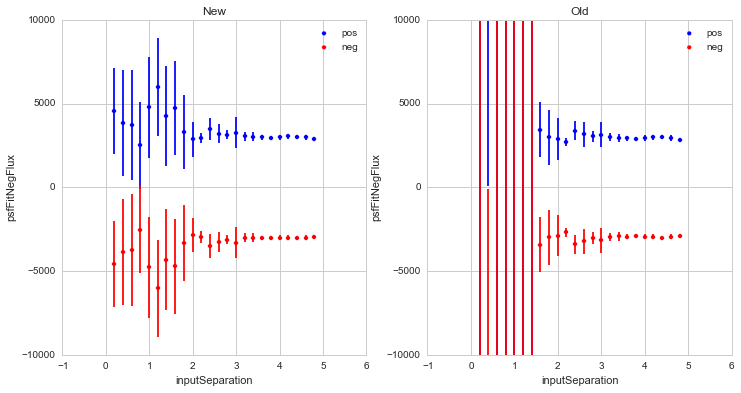

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([-10000,10000])
axes[1].set_title('Old')
axes[1].set_ylim([-10000,10000])

Try it again, this time setting different orientations as well. Next time we'll also test it as a function of scaling (source flux).

## Different orientations

In [19]:
varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)

inputs = [varTuple(z=None, w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=sep, rotAngle=rot, 
                    flux=3000., noise=1., verbose=False, display=False) for rot in orientations for sep in separations]

def processInput(i):
    output = genDipoleAndFitBothWays(z=i.z, w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfWidth=i.psfWidth, separation=i.separation, 
                                 rotAngle=i.rotAngle, flux=i.flux, noise=i.noise, verbose=False, display=False)
    output['new'] = output['new']._asdict()
    output['old'] = output['old']._asdict()
    return output

num_cores = multiprocessing.cpu_count() / 2
results2 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

(-0.2, 1.5)

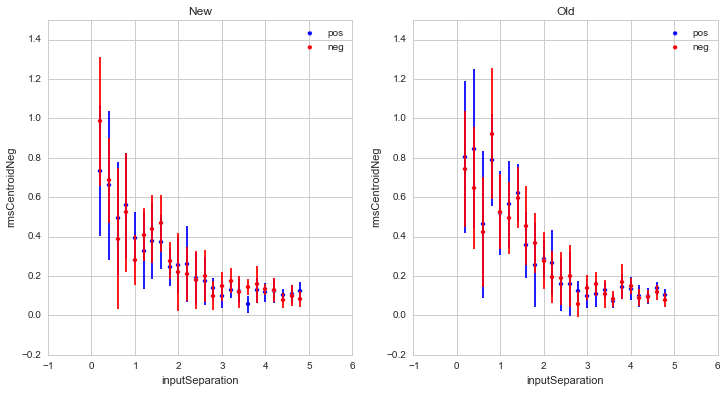

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results2])
df['rmsCentroidPos'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidX)**2. + \
                               (df.inputPosCentroidY - df.psfFitPosCentroidY)**2.)

df['rmsCentroidNeg'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidX)**2. + \
                               (df.inputNegCentroidY - df.psfFitNegCentroidY)**2.)
tmp_df = df.groupby('inputSeparation').median()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').mad() * 1.
ax = tmp_df.plot(x='inputSeparation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results2])
df['rmsCentroidPos'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidX)**2. + \
                               (df.inputPosCentroidY - df.psfFitPosCentroidY)**2.)

df['rmsCentroidNeg'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidX)**2. + \
                               (df.inputNegCentroidY - df.psfFitNegCentroidY)**2.)
tmp_df = df.groupby('inputSeparation').median()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').mad() * 1.
ax = tmp_df.plot(x='inputSeparation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([-0.2,1.5])
axes[1].set_title('Old')
axes[1].set_ylim([-0.2,1.5])

(-0.1, 1.5)

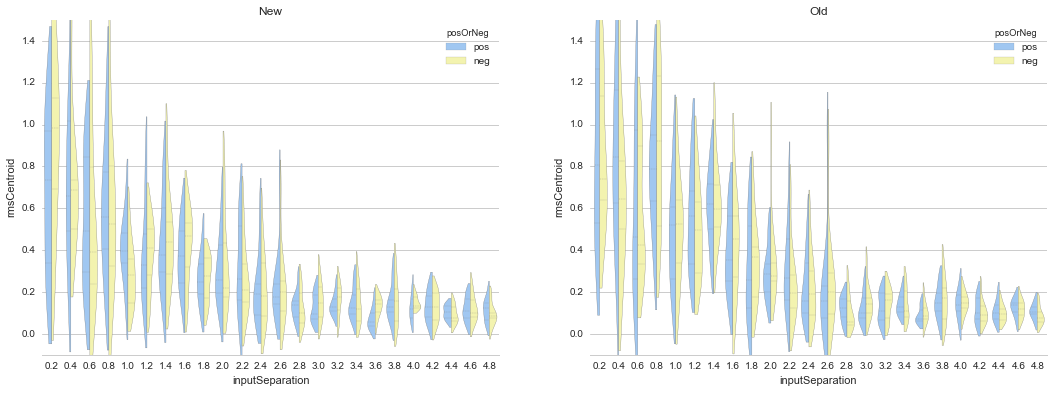

In [32]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results2])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results2])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-0.1,1.5])
axes[1].set_title('Old')
axes[1].set_ylim([-0.1,1.5])

(-1000, 40000)

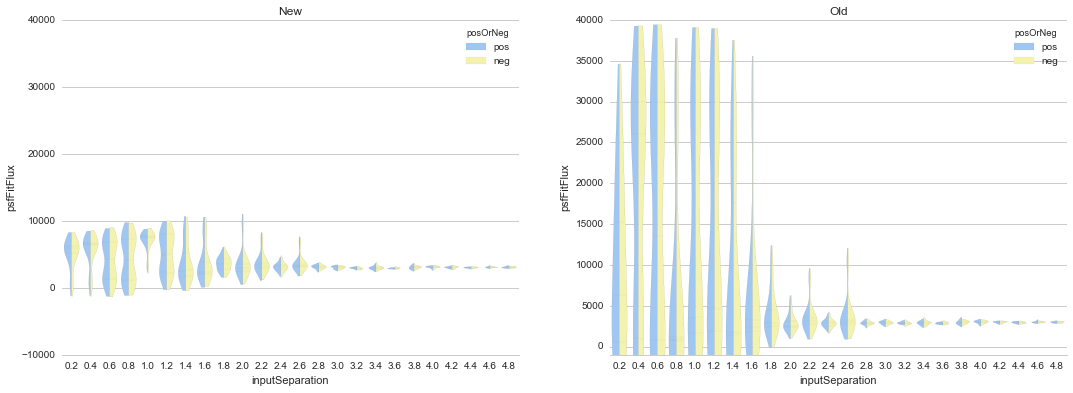

In [22]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results2])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results2])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-10000,40000])
axes[1].set_title('Old')
axes[1].set_ylim([-1000,40000])

## Different dipole fluxes (signal-to-noise)

In [23]:
varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)
fluxes = np.arange(250., 6000., 250.)

inputs = [varTuple(z=None, w=51, h=51, xc=25., yc=25., psfWidth=2.0, separation=sep, rotAngle=rot, 
                    flux=flux, noise=1., verbose=False, display=False) 
                      for flux in fluxes for rot in orientations for sep in separations]
print len(inputs)

def processInput(i):
    #print i.flux, i.separation, i.rotAngle
    output = genDipoleAndFitBothWays(z=i.z, w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfWidth=i.psfWidth, separation=i.separation, 
                                 rotAngle=i.rotAngle, flux=i.flux, noise=i.noise, verbose=False, display=False)
    output['new'] = output['new']._asdict()
    output['old'] = output['old']._asdict()
    return output
 
num_cores = multiprocessing.cpu_count() / 2
#results3 = [processInput(i) for i in inputs]
results3 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

5520


In [34]:
#import cPickle as pickle
#import gzip
#pickle.dump( (results, results2, results3), gzip.GzipFile( "results.p.gz", "wb" ) )

(-0.05, 1.2)

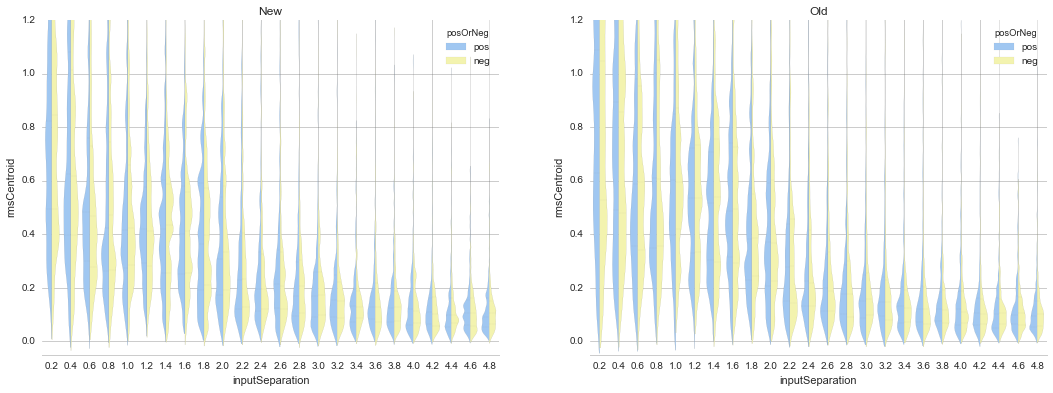

In [24]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-0.05,1.2])
axes[1].set_title('Old')
axes[1].set_ylim([-0.05,1.2])

(-1000, 30000)

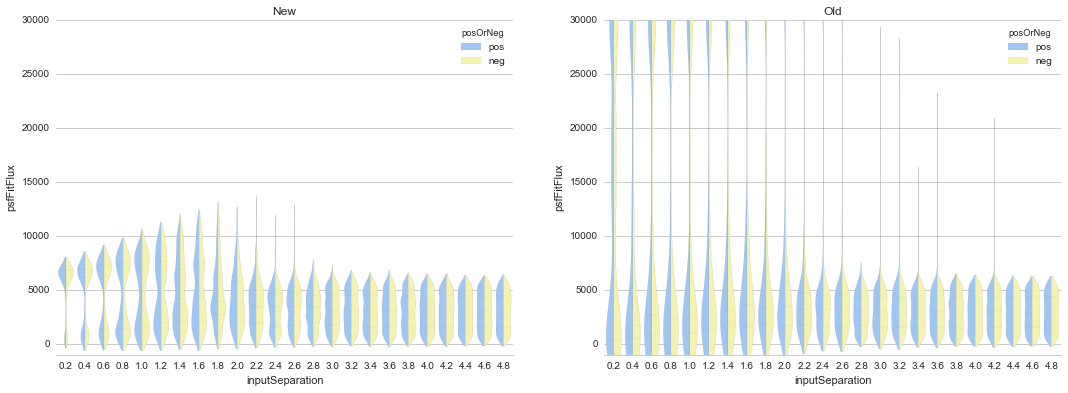

In [25]:
##### matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
#df1 = df1.loc[(df1.inputFlux == 5000.)]
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.25, linewidth=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
#df1 = df1.loc[(df1.inputFlux == 5000.)]
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.25, linewidth=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-1000,30000])
axes[1].set_title('Old')
axes[1].set_ylim([-1000,30000])

(0, 8000)

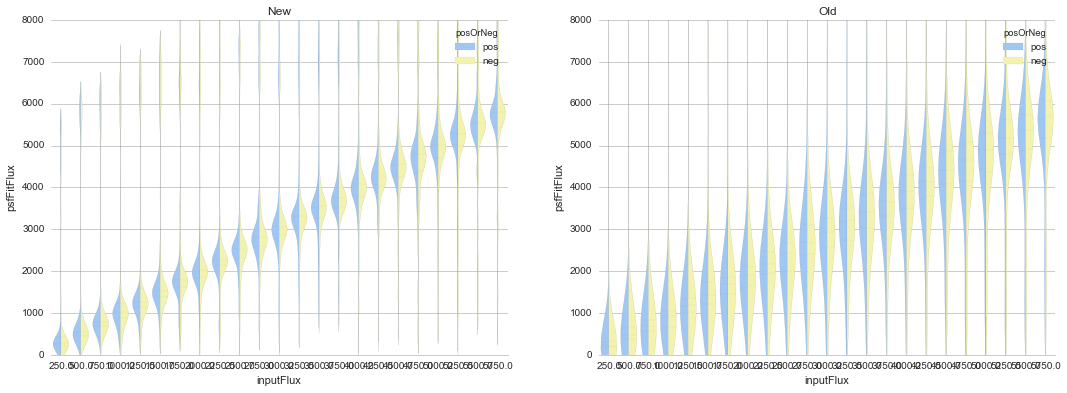

In [26]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputFlux", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.1, linewidth=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputFlux", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.1, linewidth=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([0,8000])
axes[1].set_title('Old')
axes[1].set_ylim([0,8000])

(-2000, 14000)

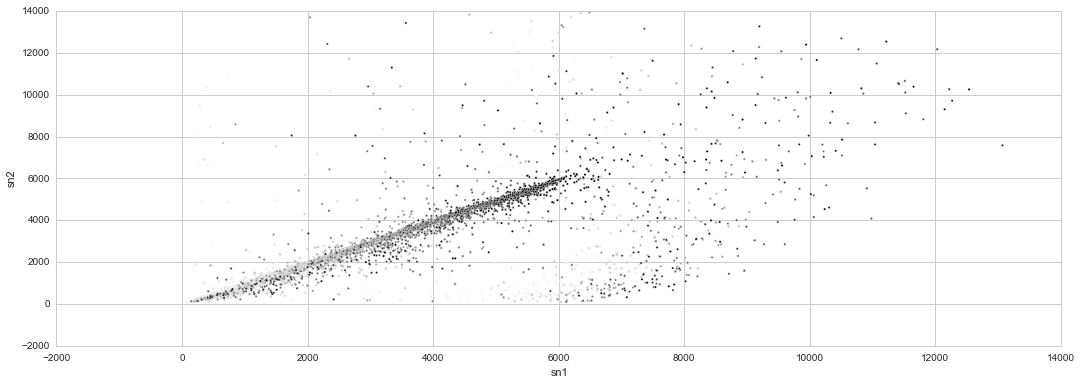

In [27]:
df1 = pd.DataFrame([res['new'] for res in results3])
df2 = pd.DataFrame([res['old'] for res in results3])
df = pd.DataFrame({'sn1': df1['psfFitPosFlux'], 'sn2': df2['psfFitPosFlux'], 'fl': df1['inputFlux']})
df = df[(df['sn1'] != np.inf) & (df['sn2'] != np.inf) & (df['sn1'] < 30000.) & (df['sn2'] < 30000.)]
ax = df.plot(x='sn1', y='sn2', kind='scatter', c=df['fl']/df['fl'].max(), s=5.)
ax.set_ylim([-2000,14000])

(-2, 3.1)

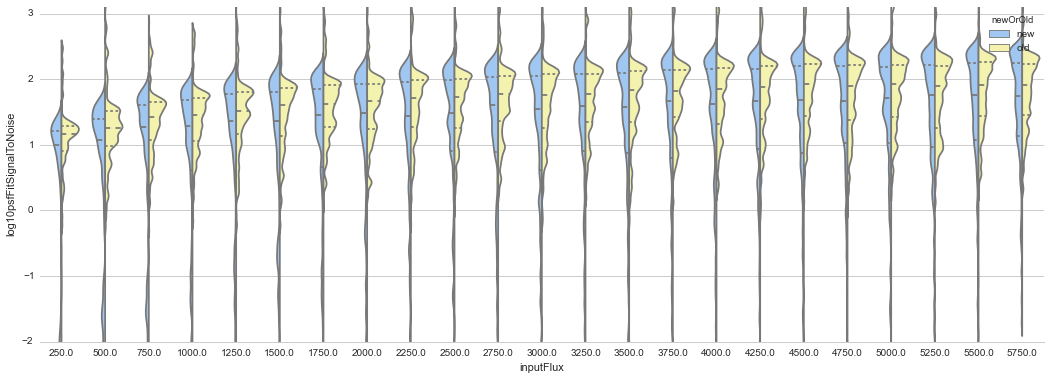

In [28]:
df = pd.DataFrame([res['new'] for res in results3])
df['newOrOld'] = np.repeat('new', df.shape[0])
df['log10psfFitSignalToNoise'] = np.log10(df['psfFitSignaltoNoise'])
df = df[(df.log10psfFitSignalToNoise != np.inf) & (df.log10psfFitSignalToNoise != np.nan) & (df.log10psfFitSignalToNoise < 8000.)]

df2 = pd.DataFrame([res['old'] for res in results3])
df2['newOrOld'] = np.repeat('old', df2.shape[0])
df2['log10psfFitSignalToNoise'] = np.log10(df2['psfFitSignaltoNoise'])
df2 = df2[(np.abs(df2.log10psfFitSignalToNoise) != np.inf) & (df2.log10psfFitSignalToNoise != np.nan) & (df2.log10psfFitSignalToNoise < 8000.)]

df = df.append(df2)

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
#fig, axes = plt.subplots(nrows=1, ncols=2)
fig = plt.figure()
ax = fig.add_subplot(111)

sns.violinplot(x="inputFlux", y="log10psfFitSignalToNoise", hue="newOrOld", data=df, split=True,
               inner="quart", palette={"new": "b", "old": "y"}, cutoff=True, bw=0.1, axis=ax)
sns.despine(left=True)
ax.set_ylim([-2,3.1])